In [20]:
#Importing all the necessary libraries and functions 
import pandas as pd
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from networkx.algorithms.community import girvan_newman
from itertools import combinations

In [21]:
# Part 1: Extracting the Data
import tarfile

# Define the path to the tar.gz file
tar_path = 'facebook.tar.gz'

# Function to extract content from the tar file
def extract_file_content(tar, file_name):
    member = tar.getmember(file_name)
    extracted_file = tar.extractfile(member)
    if extracted_file is not None:
        return extracted_file.read().decode('utf-8')
    return ""

# Extract featnames files
with tarfile.open(tar_path, 'r:gz') as tar:
    featnames_files = [
        'facebook/3980.featnames', 'facebook/1684.featnames', 'facebook/698.featnames',
        'facebook/1912.featnames', 'facebook/414.featnames', 'facebook/3437.featnames',
        'facebook/348.featnames', 'facebook/686.featnames', 'facebook/107.featnames'
    ]
    
    combined_content = ""
    for file_name in featnames_files:
        combined_content += extract_file_content(tar, file_name) + "\n"

# Process combined content
split_data = combined_content.splitlines()

user_education_concentration = {}
user_education_degree = {}

# Create mapping for users with education concentration in their profiles
for line in split_data:
    if 'education;concentration;id;anonymized' in line:
        parts = line.split(';')
        user_id = parts[0]
        concentration = parts[2] + parts[3]
        if user_id not in user_education_concentration:
            user_education_concentration[user_id] = []
        user_education_concentration[user_id].append(concentration)

# Create mapping for users with education degree in their profiles
for line in split_data:
    if 'education;degree;id;anonymized' in line:
        parts = line.split(';')
        user_id = parts[0]
        degree = parts[2] + parts[3]
        if user_id not in user_education_degree:
            user_education_degree[user_id] = []
        user_education_degree[user_id].append(degree)

# Check extracted data
print("Extracted user education concentration mapping:")
print(user_education_concentration)
print("\nExtracted user education degree mapping:")
print(user_education_degree)


Extracted user education concentration mapping:
{'1 education': ['idanonymized feature 14'], '12 education': ['idanonymized feature 1007', 'idanonymized feature 217', 'idanonymized feature 14', 'idanonymized feature 13'], '13 education': ['idanonymized feature 13', 'idanonymized feature 312', 'idanonymized feature 1009', 'idanonymized feature 213'], '14 education': ['idanonymized feature 385', 'idanonymized feature 388', 'idanonymized feature 14'], '15 education': ['idanonymized feature 14', 'idanonymized feature 15', 'idanonymized feature 214'], '16 education': ['idanonymized feature 762', 'idanonymized feature 389', 'idanonymized feature 15'], '17 education': ['idanonymized feature 1008', 'idanonymized feature 1174', 'idanonymized feature 215', 'idanonymized feature 383'], '18 education': ['idanonymized feature 1009', 'idanonymized feature 338', 'idanonymized feature 216', 'idanonymized feature 13'], '19 education': ['idanonymized feature 388', 'idanonymized feature 392', 'idanonymiz

In [22]:
#Part 2 + 3: forming network with collaborative filtering 

# Initialize the graph
G = nx.Graph()

# Add nodes for each user
all_users = list(set(user_education_concentration.keys()).union(user_education_degree.keys()))
G.add_nodes_from(all_users)

# Collaborative Filtering Part
# Create a combined user-education dictionary
all_education = {}

for user_id, concentrations in user_education_concentration.items():
    all_education[user_id] = concentrations

for user_id, degrees in user_education_degree.items():
    if user_id not in all_education:
        all_education[user_id] = degrees
    else:
        all_education[user_id].extend(degrees)

# Create a user-education matrix
all_education_items = list(set([item for sublist in all_education.values() for item in sublist]))
user_education_matrix = pd.DataFrame(index=all_users, columns=all_education_items).fillna(0)

for user, items in all_education.items():
    for item in items:
        user_education_matrix.at[user, item] = 1

# Calculate cosine similarity between users
user_similarity = cosine_similarity(user_education_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=all_users, columns=all_users)

# Set a threshold for similarity to add edges
similarity_threshold = 0.5

for user1 in user_similarity_df.index:
    for user2 in user_similarity_df.columns:
        if user1 != user2 and user_similarity_df.loc[user1, user2] > similarity_threshold:
            G.add_edge(user1, user2, weight=user_similarity_df.loc[user1, user2])

# Check if edges were added correctly
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 87
Number of edges: 26


In [25]:
#Part 4 + 5: Using the improved girvan-newman method in relation to our collaborative filtering  

def improved_girvan_newman(G, max_iter=None):
    if max_iter is None:
        max_iter = G.number_of_edges()
    
    #Nested method for getting the most central edge
    def most_central_edge(G):
        centrality = nx.edge_betweenness_centrality(G)
        return max(centrality, key=centrality.get)

    components = [c for c in nx.connected_components(G)]
    iteration = 0

    while len(components) == 1 and iteration < max_iter:
        # Get the edge to remove
        edge = most_central_edge(G)
        # Remove all edges with the highest centrality
        edges_to_remove = [e for e in G.edges if G.edges[e] == G.edges[edge]]
        G.remove_edges_from(edges_to_remove)
        components = [c for c in nx.connected_components(G)]
        iteration += 1

    return [list(c) for c in components]

# Apply the improved Girvan-Newman algorithm
communities = improved_girvan_newman(G)

print("Detected communities:")
for i, community in enumerate(communities):
    print(f"Community {i+1}: {community}")


Detected communities:
Community 1: ['19 education']
Community 2: ['84 education', '87 education', '41 education']
Community 3: ['59 education']
Community 4: ['9 education', '12 education']
Community 5: ['25 education']
Community 6: ['58 education']
Community 7: ['18 education']
Community 8: ['30 education']
Community 9: ['7 education', '1 education', '6 education', '45 education', '23 education', '4 education']
Community 10: ['86 education', '82 education', '39 education']
Community 11: ['49 education']
Community 12: ['26 education']
Community 13: ['34 education']
Community 14: ['72 education']
Community 15: ['83 education']
Community 16: ['56 education']
Community 17: ['2 education', '5 education', '40 education', '79 education', '35 education', '80 education']
Community 18: ['31 education']
Community 19: ['47 education']
Community 20: ['36 education']
Community 21: ['54 education']
Community 22: ['27 education']
Community 23: ['62 education']
Community 24: ['42 education']
Community 

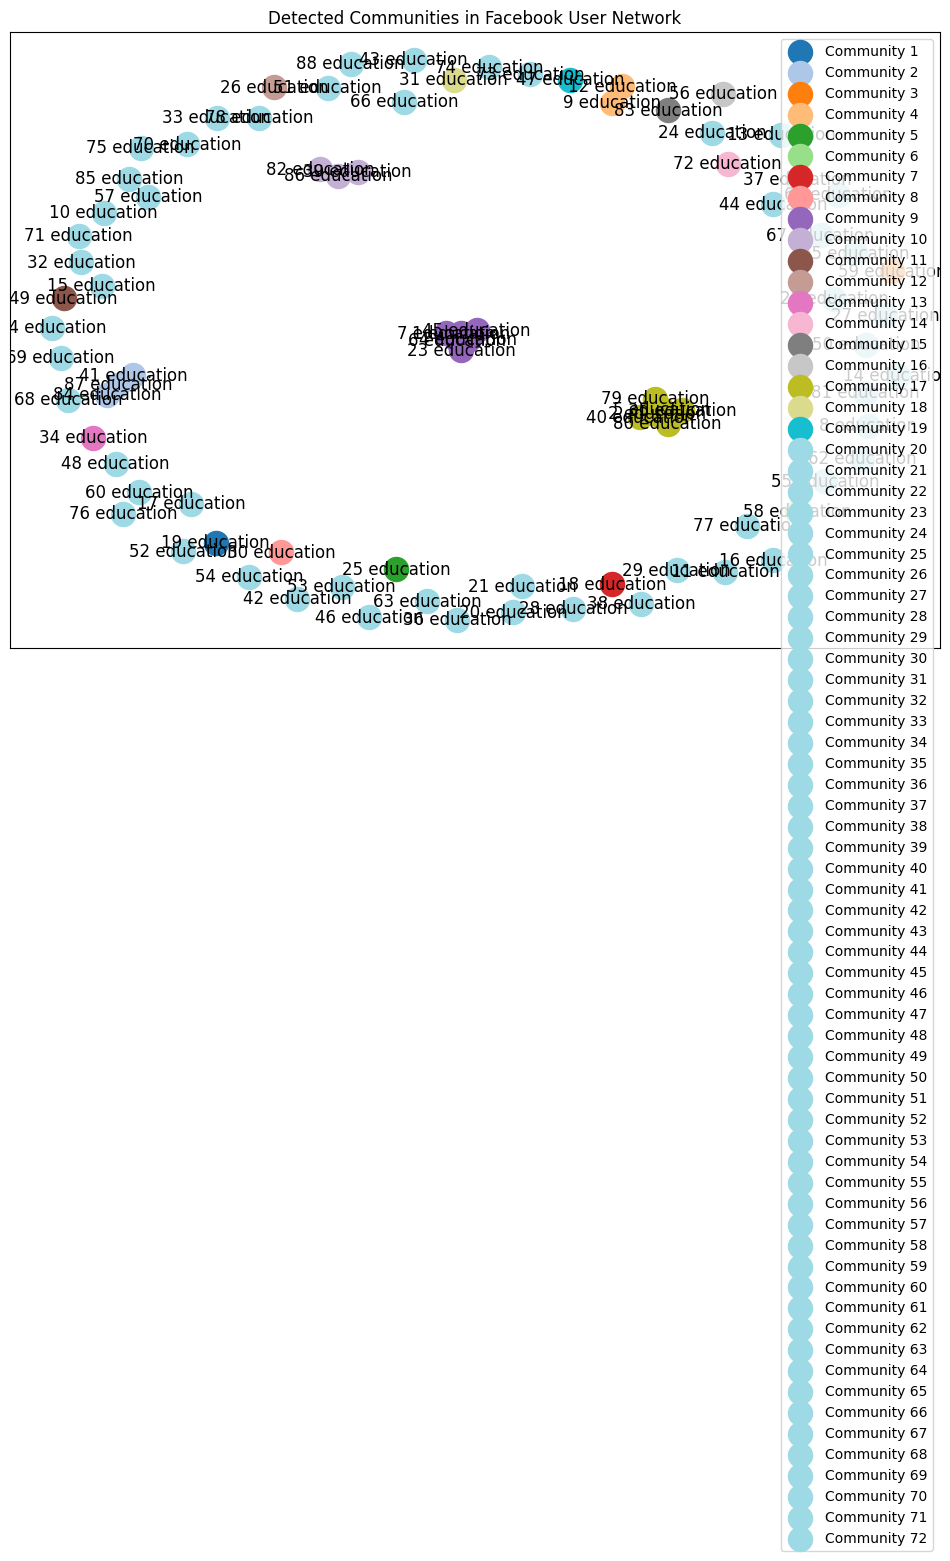

In [26]:
#Part 4: Visualize the communities
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))

# Assign a color to each community
colors = plt.get_cmap('tab20')(range(len(communities)))
for community, color in zip(communities, colors):
    nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=[color], label=f'Community {communities.index(community) + 1}')
    
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos)

plt.title("Detected Communities in Facebook User Network")
plt.legend()
plt.show()